In [1]:
import pandas as pd
import sys
sys.path.append("../lib")
import seaborn as sns
import matplotlib.pyplot as plt
from utils import iterate_over
from utils import load_config_and_check
from inspector import Inspector
import os

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
EXPERIMENT_VERSION = "08"
config = load_config_and_check(f"../config/experiment_v{EXPERIMENT_VERSION}.yaml")
comaprison_names = [e["name"] for e in config['comparisons']]
print(f"Avilable comparisons: {comaprison_names}")
COMPARISON_NAME = "cross_platform"
FOLDER_EXECUTIONS = os.path.join(config["experiment_folder"], COMPARISON_NAME, "executions")

Avilable comparisons: ['cross_platform']


In [5]:
PATH_CSV_RESULTS = f"../data/experiment_v{EXPERIMENT_VERSION}/cross_platform/predictions/40k_comparisons.csv"
df_results = pd.read_csv(PATH_CSV_RESULTS, index_col=0)
df_results.head()

,program_id,p_value_40k,stat_40k
0,0,0.939535,0.003711
1,1,0.997578,0.002759
2,10,0.999975,0.002173
3,100,0.181858,0.007642
4,1000,0.066557,0.009106


In [6]:
sherlock = Inspector(folder_executions=FOLDER_EXECUTIONS)

In [22]:
sherlock.inspect(df=df_results, divergent_id=2734, colname_pvalue="p_value_40k")

In [23]:
sherlock.p1_results

{'00000000000011': 17,
 '00010000110010': 8240,
 '00010100110000': 1,
 '00010000000110': 520,
 '00000000110100': 3,
 '00000000000111': 10,
 '00000000110011': 127,
 '00000100000010': 43,
 '00000000000010': 2136,
 '00010000000010': 1099,
 '00000100000110': 25,
 '00010000000011': 11,
 '00010000110110': 3695,
 '00000100110011': 2,
 '00010100000110': 10,
 '00010000000111': 7,
 '00010100000010': 31,
 '00010100110010': 172,
 '00000000110010': 15878,
 '00000000110111': 60,
 '00010000110111': 38,
 '00000100110010': 329,
 '00010100110011': 2,
 '00010000110011': 63,
 '00000100110110': 146,
 '00010100110110': 80,
 '00000000110000': 4,
 '00010100110111': 2,
 '00000000000110': 987,
 '00000000110110': 7221,
 '00010000110100': 1}

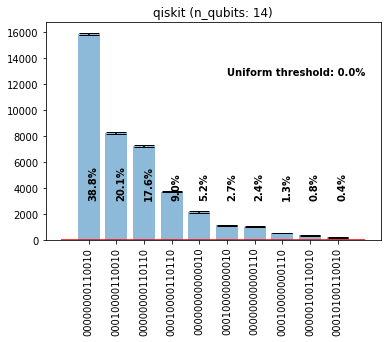

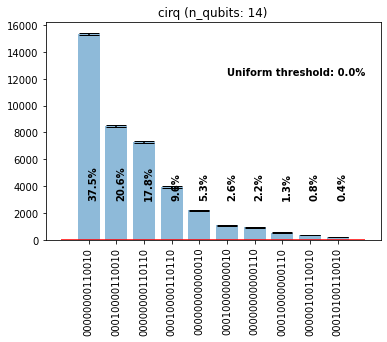

In [24]:
sherlock.plot_execution_top_k()

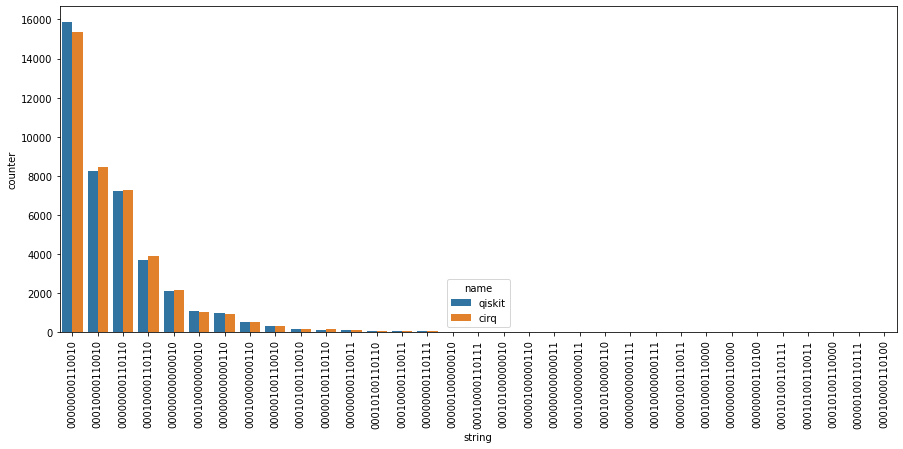

In [25]:
sherlock.plot_histogram_together(top_perc=1, figsize=(15, 6))

In [26]:
sherlock.p_value

0.000989979284444

<Figure size 1080x432 with 0 Axes>

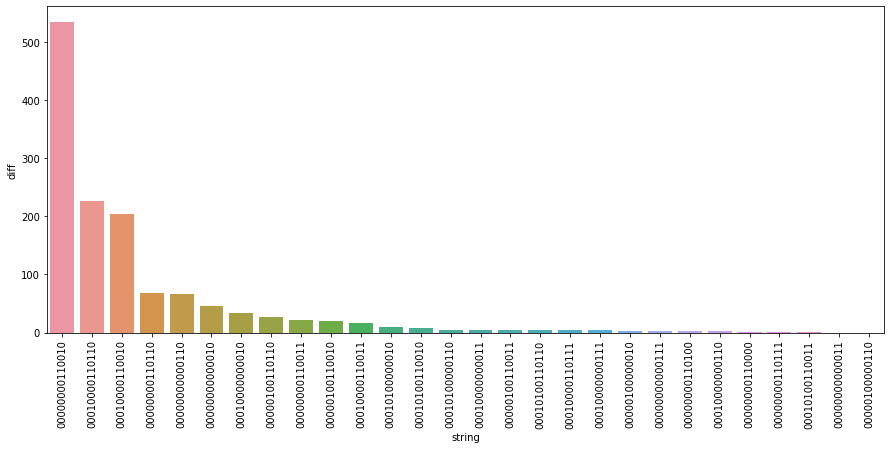

In [27]:
sherlock.plot_most_divergent_output(top_perc=1, figsize=(15, 6))